In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def amp_spec(data):
    return abs(np.fft.rfft(data))

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory


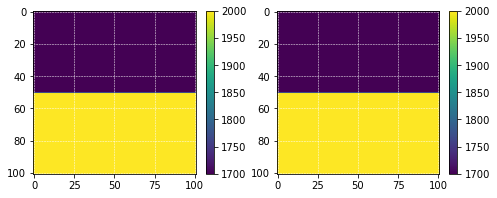

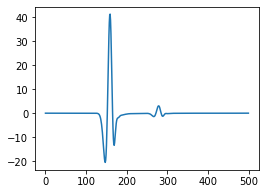

In [2]:
## with reflections
!makevel nz=51 nx=$nx v000=1700 > vp1
!makevel nz=50 nx=$nx v000=2000 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

!makevel nz=1 nx=$nx v000=100 > topo
#!makevel nz=1 nx=$nx v000=400 > topo

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup.in > out_fwd

!rm -r results_fwd; mv results  results_fwd

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))

## FWI gradient for vp

In [13]:
# # with reflections
# !makevel nz=51 nx=$nx v000=1600 > vp1
# !makevel nz=50 nx=$nx v000=1800 > vp2
# !cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
# !rm vp1 vp2 rho1 rho2 tmp*

# w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model

!cp setup.in setup_grad.in
!echo "PARAMETER           'vp:1500:2000'" >> setup_grad.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad.in
!echo "JOB                 'gradient'" >> setup_grad.in

!../../exe/FWI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


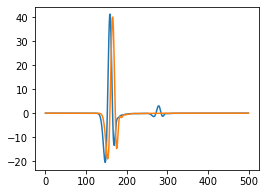

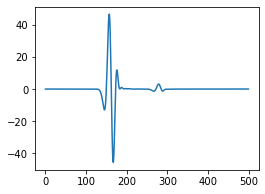

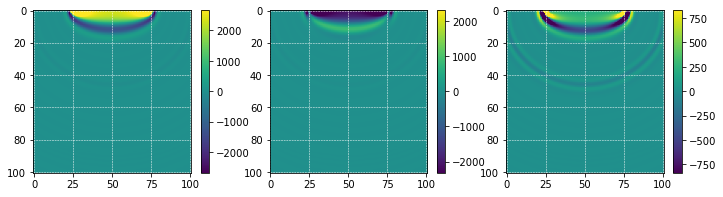

In [14]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/dsyn_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
tmp=read('results_grad/correlate_gradient',n=(2*nx,nz)); tmp1=tmp[:,:nx]/1600**2; tmp2=tmp[:,nx:2*nx]
plt.subplot(1,3,1);imshow(tmp1,perc=99) #gikpa/c^2
plt.subplot(1,3,2);imshow(tmp2,perc=99) #gbuo
plt.subplot(1,3,3);imshow(tmp1+tmp2,perc=99) #scaled grho under vp-rho, =ISIC

### GradientTest

In [12]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

!make App=FWI

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'vp:1500:2000'" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp-rho.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fobj

In [16]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

!make App=FWI

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'rho:800:1200'" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in
#!echo "ALPHAS '1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp-rho.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fobj

In [17]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

!make App=FWI

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'rho:500:3000'" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp-rho.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fobj